<a href="https://colab.research.google.com/github/PraneetVR/IIITDMJ-DL-Summer-School-Program-Assignments/blob/main/Week_3_Day_1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 3 Day 1 Assignment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

#1. Manual Forward Pass and Backpropagation in Generator & Discriminator

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 10
hidden_dim = 128
output_dim_generator = 2  # For the toy dataset (x, y)
input_dim_discriminator = 2 # For the toy dataset (x, y)
hidden_dim_discriminator = 128
learning_rate = 0.0002
num_epochs = 200
batch_size = 64
num_samples_toy = 10000

def generate_real_data(num_samples):
    center_x = np.random.uniform(-2, 2, num_samples)
    center_y = np.random.uniform(-2, 2, num_samples)
    x = center_x + np.random.normal(0, 0.1, num_samples)
    y = center_y + np.random.normal(0, 0.1, num_samples)
    data = np.stack((x, y), axis=-1)
    return torch.tensor(data, dtype=torch.float32)

In [ ]:
def initialize_weights(input_dim, output_dim):
    # Using Xavier initialization idea
    limit = np.sqrt(6 / (input_dim + output_dim))
    return torch.randn(input_dim, output_dim) * limit

class Generator(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.W1 = torch.nn.Parameter(initialize_weights(latent_dim, hidden_dim))
        self.b1 = torch.nn.Parameter(torch.zeros(hidden_dim))
        self.W2 = torch.nn.Parameter(initialize_weights(hidden_dim, hidden_dim))
        self.b2 = torch.nn.Parameter(torch.zeros(hidden_dim))
        self.W3 = torch.nn.Parameter(initialize_weights(hidden_dim, output_dim))
        self.b3 = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, z):
        h1 = torch.relu(torch.matmul(z, self.W1) + self.b1)
        h2 = torch.relu(torch.matmul(h1, self.W2) + self.b2)
        output = torch.tanh(torch.matmul(h2, self.W3) + self.b3)
        return output

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W1 = torch.nn.Parameter(initialize_weights(input_dim, hidden_dim))
        self.b1 = torch.nn.Parameter(torch.zeros(hidden_dim))
        self.W2 = torch.nn.Parameter(initialize_weights(hidden_dim, hidden_dim))
        self.b2 = torch.nn.Parameter(torch.zeros(hidden_dim))
        self.W3 = torch.nn.Parameter(initialize_weights(hidden_dim, 1))
        self.b3 = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        h1 = torch.nn.functional.leaky_relu(torch.matmul(x, self.W1) + self.b1, 0.2)
        h2 = torch.nn.functional.leaky_relu(torch.matmul(h1, self.W2) + self.b2, 0.2)
        output = torch.matmul(h2, self.W3) + self.b3
        return output

generator = Generator(latent_dim, hidden_dim, output_dim_generator).to(device)
discriminator = Discriminator(input_dim_discriminator, hidden_dim_discriminator).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

real_data_all = generate_real_data(num_samples_toy).to(device)

In [ ]:
g_losses = []
d_losses = []
sampled_data_epochs = {}

for epoch in range(num_epochs):
    real_indices = torch.randint(0, num_samples_toy, (batch_size,))
    real_data = real_data_all[real_indices]

    optimizer_d.zero_grad()

    d_output_real = discriminator(real_data)
    d_loss_real = criterion(d_output_real, torch.ones_like(d_output_real).to(device))

    z = torch.randn(batch_size, latent_dim).to(device)
    fake_data = generator(z).detach()
    d_output_fake = discriminator(fake_data)
    d_loss_fake = criterion(d_output_fake, torch.zeros_like(d_output_fake).to(device))

    d_loss = (d_loss_real + d_loss_fake) / 2
    d_loss.backward()
    optimizer_d.step()

    optimizer_g.zero_grad()

    z = torch.randn(batch_size, latent_dim).to(device)
    fake_data = generator(z)
    d_output_fake = discriminator(fake_data)
    g_loss = criterion(d_output_fake, torch.ones_like(d_output_fake).to(device))

    g_loss.backward()
    optimizer_g.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 50 == 0 or epoch in [5, 50, 100, 200]:
        with torch.no_grad():
            z_sample = torch.randn(100, latent_dim).to(device)
            sampled_data = generator(z_sample).cpu().numpy()
            sampled_data_epochs[epoch] = sampled_data
        print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [0/200], D Loss: 0.7000, G Loss: 0.7443
Epoch [5/200], D Loss: 0.6831, G Loss: 0.7193
Epoch [50/200], D Loss: 0.6779, G Loss: 0.5480
Epoch [100/200], D Loss: 0.8572, G Loss: 0.3917
Epoch [150/200], D Loss: 0.4845, G Loss: 1.1172


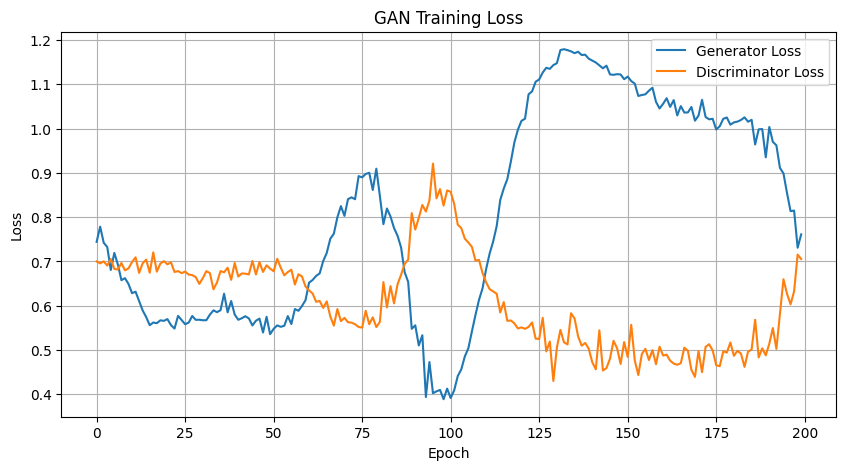

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid(True)
plt.show()

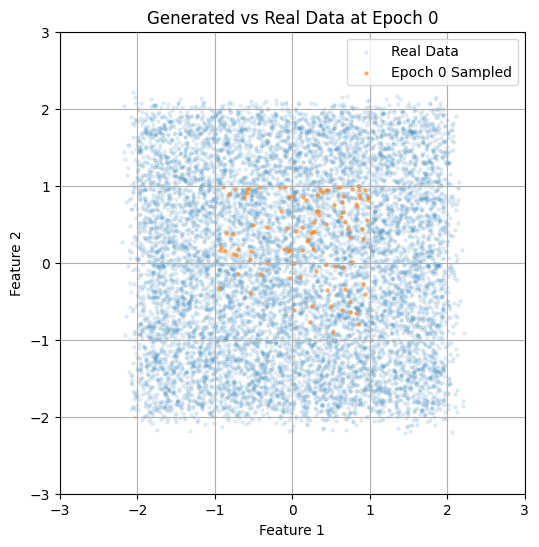

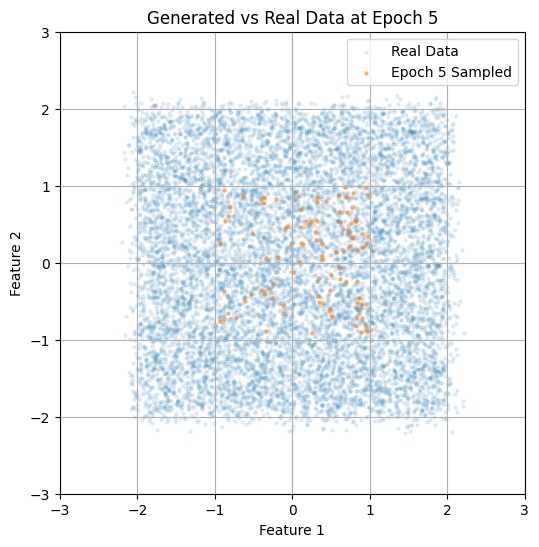

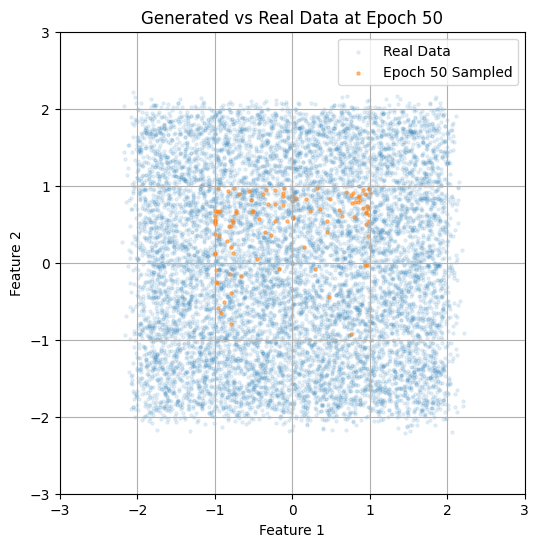

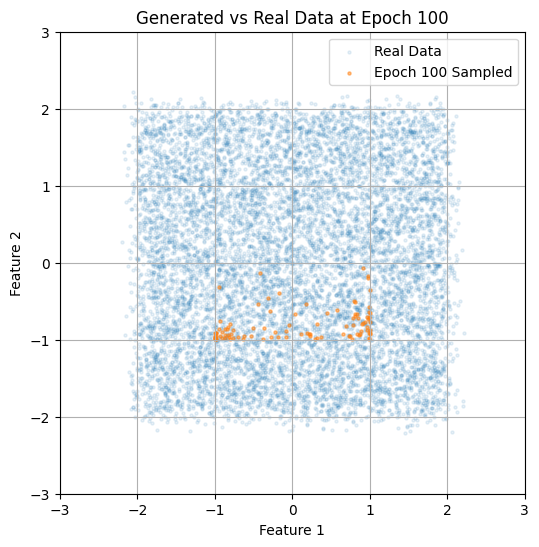

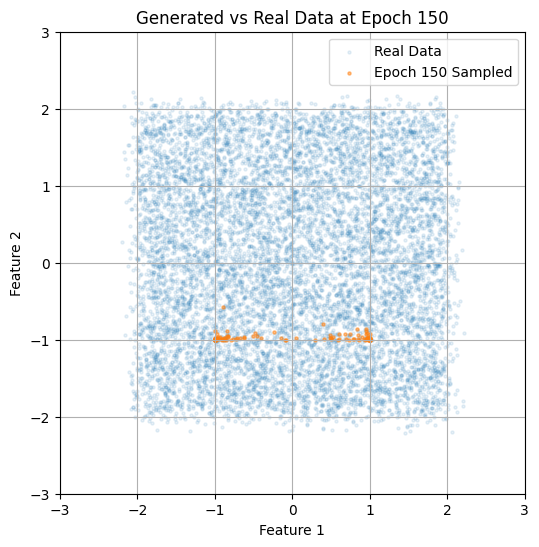

In [ ]:
for epoch, sampled_data in sampled_data_epochs.items():
    plt.figure(figsize=(6, 6))
    real_data_np = real_data_all.cpu().numpy()
    plt.scatter(real_data_np[:, 0], real_data_np[:, 1], label='Real Data', alpha=0.1, s=5)
    plt.scatter(sampled_data[:, 0], sampled_data[:, 1], label=f'Epoch {epoch} Sampled', alpha=0.5, s=5)
    plt.title(f'Generated vs Real Data at Epoch {epoch}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.grid(True)
    plt.show()

#2. Generate Augmented Data

In [ ]:
if not os.path.exists('generated_data'):
    os.makedirs('generated_data')

# Generate 1000+ new synthetic samples
num_synthetic_samples = 1000
generated_samples = []

with torch.no_grad():
    # Generate in batches if needed, to manage memory
    for i in range(0, num_synthetic_samples, batch_size):
        batch_size_current = min(batch_size, num_synthetic_samples - i)
        z = torch.randn(batch_size_current, latent_dim).to(device)
        fake_data_batch = generator(z).cpu().numpy()
        generated_samples.append(fake_data_batch)

generated_samples = np.vstack(generated_samples)
print(f"Generated {len(generated_samples)} synthetic samples.")

# Save the generated data to a file
np.save('generated_data/synthetic_samples.npy', generated_samples)
print("Synthetic samples saved to 'generated_data/synthetic_samples.npy'")

Generated 1000 synthetic samples.
Synthetic samples saved to 'generated_data/synthetic_samples.npy'


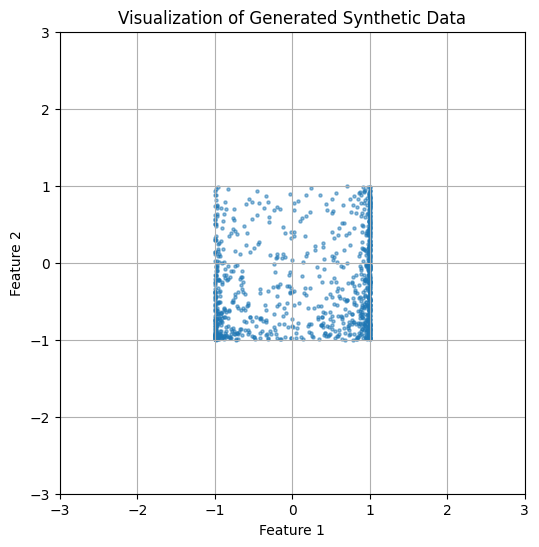

Original data samples: 10000
Combined dataset size: 11000


In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, s=5)
plt.title('Visualization of Generated Synthetic Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()

combined_data = np.vstack((real_data_all.cpu().numpy(), generated_samples))
print(f"Original data samples: {len(real_data_all)}")
print(f"Combined dataset size: {len(combined_data)}")

#3. Train a Classifier from Scratch on Original vs Augmented Dataset


--- Training on Original Dataset ---
Epoch [0/100], Loss: 0.2964
Epoch [20/100], Loss: 0.0120
Epoch [40/100], Loss: 0.0059
Epoch [60/100], Loss: 0.0034
Epoch [80/100], Loss: 0.0021
Evaluation on Original:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  Confusion Matrix:
[[1002    0]
 [   0  998]]


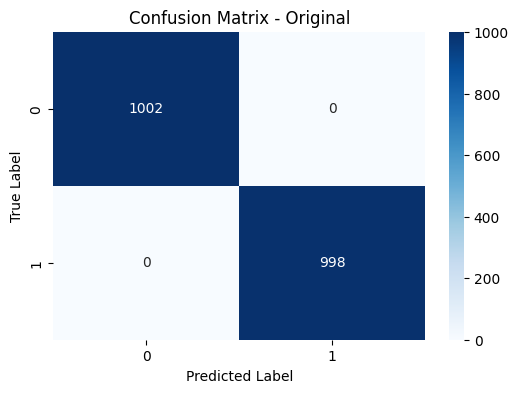


--- Training on Augmented Dataset ---
Epoch [0/100], Loss: 0.4680
Epoch [20/100], Loss: 0.0131
Epoch [40/100], Loss: 0.0060
Epoch [60/100], Loss: 0.0034
Epoch [80/100], Loss: 0.0022
Evaluation on Augmented:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  Confusion Matrix:
[[1080    0]
 [   0 1120]]


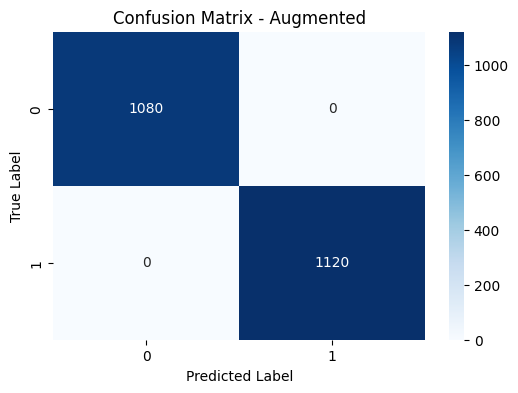

In [ ]:
class ManualClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.W1 = torch.nn.Parameter(initialize_weights(input_dim, hidden_dim))
        self.b1 = torch.nn.Parameter(torch.zeros(hidden_dim))
        self.W2 = torch.nn.Parameter(initialize_weights(hidden_dim, output_dim))
        self.b2 = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        h1 = torch.relu(torch.matmul(x, self.W1) + self.b1)
        output = torch.matmul(h1, self.W2) + self.b2
        return output

def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    print(f"\n--- Training on {dataset_name} Dataset ---")
    input_dim = X_train.shape[1]
    hidden_dim_classifier = 64
    output_dim_classifier = 2

    classifier = ManualClassifier(input_dim, hidden_dim_classifier, output_dim_classifier).to(device)
    optimizer_c = optim.Adam(classifier.parameters(), lr=0.001)
    criterion_c = nn.CrossEntropyLoss()

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    num_epochs_classifier = 100

    for epoch in range(num_epochs_classifier):
        classifier.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_c.zero_grad()

            outputs = classifier(inputs)
            loss = criterion_c(outputs, labels)

            loss.backward()
            optimizer_c.step()

            running_loss += loss.item()

        if epoch % 20 == 0:
            print(f"Epoch [{epoch}/{num_epochs_classifier}], Loss: {running_loss / len(train_loader):.4f}")

    classifier.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

        outputs = classifier(X_test_tensor)
        _, predicted = torch.max(outputs, 1)

        y_true = y_test_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        print(f"Evaluation on {dataset_name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print("  Confusion Matrix:")
        print(cm)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

real_data_np = real_data_all.cpu().numpy()
original_labels = (real_data_np[:, 0] > 0).astype(int)

X_original = real_data_np
y_original = original_labels

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42, stratify=y_original)

train_and_evaluate(X_train_original, y_train_original, X_test_original, y_test_original, "Original")

generated_labels = (generated_samples[:, 0] > 0).astype(int)

X_augmented = np.vstack((X_original, generated_samples))
y_augmented = np.concatenate((y_original, generated_labels))

X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)

train_and_evaluate(X_train_augmented, y_train_augmented, X_test_augmented, y_test_augmented, "Augmented")